<a href="https://colab.research.google.com/github/mercurialw0rld/V1-Neural-Encoding-PyTorch/blob/main/v1neuralmodeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelando la Respuesta Neuronal a Estímulos Visuales con Redes Neuronales

Este cuaderno explora cómo una red neuronal simple puede modelar la respuesta de una neurona individual a un estímulo de luz. Utilizaremos datos reales de neurociencia para entrenar y evaluar nuestro modelo.

## Objetivo
Construir y entrenar una red neuronal para predecir la tasa de disparo de una neurona (spikes) en función de la intensidad de un estímulo visual (contraste de luz).

### 1. Carga y Preprocesamiento de Datos

Primero, cargamos el conjunto de datos `steinmetz_part1.npz`, que contiene grabaciones de actividad neuronal y estímulos. Seleccionamos una sesión específica y extraemos el contraste total del estímulo y el conteo de espigas de una neurona en particular. Los datos se convierten a tensores de PyTorch para ser utilizados en la red neuronal.

- **`contraste_total`**: Representa la intensidad del estímulo de luz (suma del contraste izquierdo y derecho).
- **`conteo_spikes`**: Matriz con el número de espigas (disparos) de cada neurona en cada instante de tiempo.
- **`disparo_primerNeurona`**: Selecciona la actividad de una neurona específica.
- **`tensorEstimulosLuz` y `respuestaNeuronal`**: Los datos se transforman en tensores `torch.float32` y se ajusta su forma con `.unsqueeze(1)` para que sean compatibles con las capas de entrada y salida del modelo (formato `[batch_size, features]`).

In [ ]:
# imports
import torch
from torch import nn
import matplotlib
import matplotlib.pyplot as plt
import os, requests
import numpy as np

In [ ]:
# descarga de dataset de actividad neuronal y estimulos
fname = "steinmetz_part1.npz"
url = "https://osf.io/agvxh/download"

if not os.path.exists(fname):
  print("Descargando")
  r = requests.get(url)
  with open(fname, "wb") as fid:
    fid.write(r.content)
else:
  print("Los datos ya están descargados")

alldata = np.load(fname, allow_pickle=True)['dat']
sesion = alldata[11]


Los datos ya están descargados


In [89]:
contraste_total = sesion['contrast_left'] + sesion['contrast_right'] # seleccionamos el contraste
conteo_spikes = np.sum(sesion['spks'], axis=2)
disparo_primerNeurona = conteo_spikes[87]
respuestaNeuronal = torch.from_numpy(disparo_primerNeurona).type(torch.float32).unsqueeze(1)
tensorEstimulosLuz = torch.from_numpy(contraste_total).type(torch.float32).unsqueeze(1)

print(tensorEstimulosLuz.shape, respuestaNeuronal.shape)

torch.Size([340, 1]) torch.Size([340, 1])


### 2. Definición del Modelo de Red Neuronal

Aquí definimos una red neuronal feedforward simple utilizando `torch.nn.Sequential`.

- **`nn.Linear(1, 16)`**: Es la primera capa oculta. Transforma la entrada de 1 característica (intensidad de luz) en 16 características (interneuronas). Realiza una operación lineal: `y = xW^T + b`.
- **`nn.ReLU()`**: Es la función de activación Rectified Linear Unit. Introduce no-linealidad en el modelo, lo cual es crucial para aprender patrones complejos. La función es `f(x) = max(0, x)`.
- **`nn.Linear(16, 1)`**: Es la capa de salida. Toma las 16 características de la capa oculta y las transforma en 1 salida (la predicción de la tasa de disparo neuronal).

### Función de Pérdida (Criterio) y Optimizador

- **`criterio = nn.MSELoss()`**: Utilizamos el Error Cuadrático Medio (Mean Squared Error) como función de pérdida. Esta función mide la diferencia promedio al cuadrado entre los valores predichos y los valores reales. `Loss = (1/N) * Σ(y_pred - y_true)^2`.
- **`optimizer = torch.optim.SGD(modelo.parameters(), lr=0.05)`**: El optimizador es el algoritmo de Descenso de Gradiente Estocástico (Stochastic Gradient Descent). Se encarga de ajustar los pesos y sesgos del modelo (`modelo.parameters()`) para minimizar la función de pérdida. `lr` (learning rate o tasa de aprendizaje) controla el tamaño de los pasos que toma el optimizador en cada iteración.

### 3. Entrenamiento del Modelo

El bucle de entrenamiento itera un número fijo de épocas (1000 en este caso). En cada época, se realizan los siguientes pasos:

1.  **`optimizer.zero_grad()`**: Reinicia los gradientes acumulados de los parámetros del modelo. Esto es importante porque, por defecto, PyTorch acumula gradientes en cada pasada.
2.  **`prediccion = modelo(tensorEstimulosLuz)`**: Se realiza una pasada hacia adelante (forward pass) para obtener las predicciones del modelo a partir de los estímulos de luz.
3.  **`loss = criterio(prediccion, respuestaNeuronal)`**: Se calcula la función de pérdida comparando las predicciones con la respuesta neuronal real.
4.  **`historical_loss.append(loss.item())`**: Se guarda el valor de la pérdida para su posterior visualización, permitiendo monitorear el progreso del entrenamiento.
5.  **`loss.backward()`**: Se calcula el gradiente de la función de pérdida con respecto a todos los parámetros del modelo. Esto es la 'propagación hacia atrás' (backpropagation).
6.  **`optimizer.step()`**: El optimizador ajusta los pesos del modelo utilizando los gradientes calculados para reducir la pérdida.

Finalmente, se grafica la `historical_loss` para visualizar cómo la pérdida disminuye con cada época, indicando que el modelo está aprendiendo.

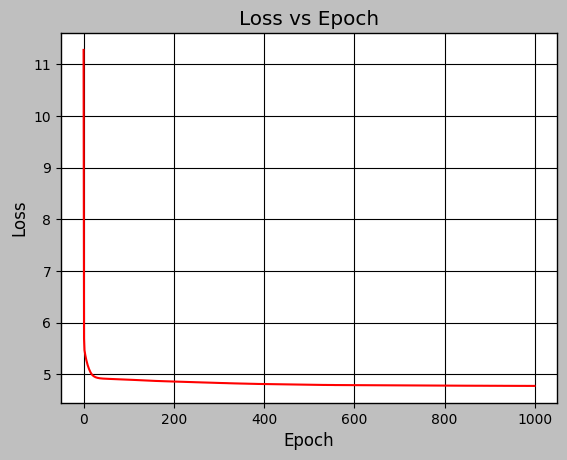

In [102]:
modelo = nn.Sequential(
    nn.Linear(1, 16),
    nn.ReLU(),
    nn.Linear(16, 1)
)
criterio = nn.MSELoss()
optimizer = torch.optim.SGD(modelo.parameters(), lr=0.05)

historical_loss = []

for epoch in range(1000):
  optimizer.zero_grad()
  prediccion = modelo(tensorEstimulosLuz)
  loss = criterio(prediccion, respuestaNeuronal)
  historical_loss.append(loss.item())
  loss.backward()
  optimizer.step()

with plt.style.context('grayscale'):
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.title("Loss vs Epoch")
  plt.plot(historical_loss, color='red')
  plt.grid(True)
  plt.show()

### 4. Visualización del Ajuste del Modelo

Una vez entrenado el modelo, es crucial visualizar cómo se ajustan sus predicciones a los datos reales. Para ello:

-   **`x_test = torch.linspace(..., 100).unsqueeze(1)`**: Se genera un conjunto de valores de estímulo de luz equiespaciados para obtener una curva de predicción suave que abarque todo el rango de estímulos presentes en los datos originales.
-   **`predicted = modelo(x_test).detach().numpy()`**: El modelo realiza predicciones sobre estos nuevos valores de estímulo. `.detach()` desconecta el tensor del grafo de cómputo para evitar el cálculo de gradientes innecesarios, y `.numpy()` lo convierte a un array de NumPy para graficar.
-   La gráfica muestra los puntos de datos originales (estímulo vs. disparo neuronal) como un `scatter plot` y la curva de predicción del modelo como una `line plot`. Esto nos permite observar visualmente qué tan bien el modelo ha capturado la tendencia general de la respuesta neuronal.

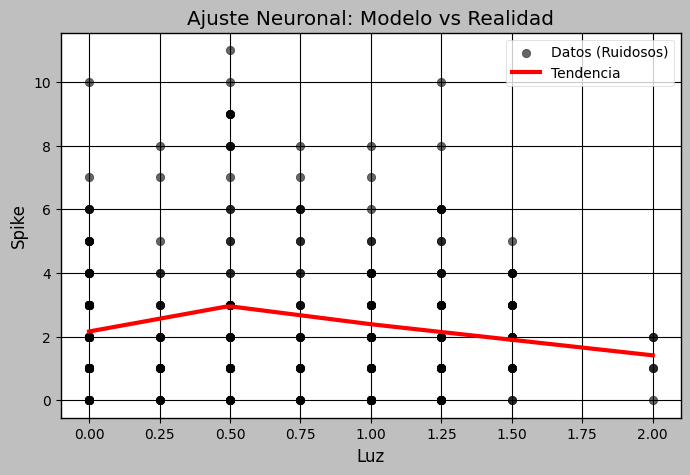

In [101]:
x_test = torch.linspace(tensorEstimulosLuz.min(), tensorEstimulosLuz.max(), 100).unsqueeze(1)
predicted = modelo(x_test).detach().numpy() # Predicciones finales

with plt.style.context('grayscale'):
  plt.figure(figsize=(8,5))
  plt.xlabel("Luz")
  plt.ylabel("Spike")
  plt.scatter(tensorEstimulosLuz, respuestaNeuronal.numpy(), label='Datos (Ruidosos)', alpha=0.6)
  plt.plot(x_test, predicted, 'r', linewidth=3, label='Tendencia')
  plt.title("Ajuste Neuronal: Modelo vs Realidad")
  plt.legend()
  plt.grid(True)
  plt.show()

### Modelado No Lineal: La Curva de Sintonización

* **El Hallazgo:** La gráfica muestra una **tendencia no monótona**. La neurona incrementa su actividad hasta un punto óptimo de contraste (aprox. 0.5) y luego disminuye su tasa de disparo ante estímulos más fuertes.
* **Interpretación Biológica:** Este comportamiento es característico de una **Curva de Sintonización (Tuning Curve)** en la corteza visual (V1). La caída en la actividad ante contrastes altos sugiere mecanismos de **inhibición envolvente** o control de ganancia, donde la red neuronal se "autoregula" para evitar la saturación.



### 5. Análisis del Factor de Fano

El Factor de Fano es una métrica utilizada en neurociencia para cuantificar la variabilidad de la tasa de disparo de una neurona. Se define como la razón entre la varianza y la media del número de espigas (disparos) en un intervalo de tiempo dado.

-   **Factor de Fano = Varianza / Media**

**Interpretación:**
-   Si el Factor de Fano es aproximadamente **1**, la variabilidad de los disparos se asemeja a un proceso de Poisson, que es un modelo común para eventos aleatorios e independientes.
-   Si el Factor de Fano es **menor que 1**, la neurona exhibe una variabilidad menor de lo esperado por un proceso de Poisson (sub-poissoniana), lo que podría indicar mecanismos de regulación o interacciones inhibitorias.
-   Si el Factor de Fano es **mayor que 1**, la neurona muestra una variabilidad mayor de lo esperado (super-poissoniana). En nuestro caso, un Factor de Fano de **2.0772** es significativamente mayor que 1. Esto indica que la respuesta de esta neurona específica es **altamente variable**, lo que es un hallazgo común en muchas neuronas corticales y puede reflejar la complejidad de la integración de señales o la presencia de ruido intrínseco.


In [100]:
varianza_real = torch.var(respuestaNeuronal)
media_real = torch.mean(respuestaNeuronal)

fano_factor = varianza_real / media_real

print(f"Media de disparos: {media_real:.4f}")
print(f"Varianza de disparos: {varianza_real:.4f}")
print(f"Factor de Fano: {fano_factor:.4f}")

Media de disparos: 2.3706
Varianza de disparos: 4.9242
Factor de Fano: 2.0772


* **Conclusión:** La neurona exhibe una variabilidad mucho mayor que la esperada por el azar puro (Poisson, $F=1$). Esto es consistente con neuronas que disparan en **ráfagas (bursting)**. El "ruido" observado en la gráfica no es error, sino una característica intrínseca del código neural de esta célula.
